In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm.notebook import tqdm, trange
from copy import deepcopy
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

# own imports
from src.utils import create_nfl_field
from src.utils import load_data
from src.utils import life_expectancy

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)

In [2]:
games, plays, players, scouting, plays_with_collapse, off_cols, def_cols = (
        load_data()
    )
players_with_collapse = pd.merge(
        scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
            ["gameId", "playId", "nflId", "pff_role"]
        ],
        plays_with_collapse,
        how="right",
        on=["gameId", "playId"],
    )


100%|██████████| 8557/8557 [00:01<00:00, 4311.75it/s]


timed_pocketsizes.shape=(8557, 10)


In [3]:

off_team_cols = [
        "possessionTeam_ATL",
        "possessionTeam_BAL",
        "possessionTeam_BUF",
        "possessionTeam_CAR",
        "possessionTeam_CHI",
        "possessionTeam_CIN",
        "possessionTeam_CLE",
        "possessionTeam_DAL",
        "possessionTeam_DEN",
        "possessionTeam_DET",
        "possessionTeam_GB",
        "possessionTeam_HOU",
        "possessionTeam_IND",
        "possessionTeam_JAX",
        "possessionTeam_KC",
        "possessionTeam_LA",
        "possessionTeam_LAC",
        "possessionTeam_LV",
        "possessionTeam_MIA",
        "possessionTeam_MIN",
        "possessionTeam_NE",
        "possessionTeam_NO",
        "possessionTeam_NYG",
        "possessionTeam_NYJ",
        "possessionTeam_PHI",
        "possessionTeam_PIT",
        "possessionTeam_SEA",
        "possessionTeam_SF",
        "possessionTeam_TB",
        "possessionTeam_TEN",
        "possessionTeam_WAS",
    ]

def_team_cols = [
        "defensiveTeam_ATL",
        "defensiveTeam_BAL",
        "defensiveTeam_BUF",
        "defensiveTeam_CAR",
        "defensiveTeam_CHI",
        "defensiveTeam_CIN",
        "defensiveTeam_CLE",
        "defensiveTeam_DAL",
        "defensiveTeam_DEN",
        "defensiveTeam_DET",
        "defensiveTeam_GB",
        "defensiveTeam_HOU",
        "defensiveTeam_IND",
        "defensiveTeam_JAX",
        "defensiveTeam_KC",
        "defensiveTeam_LA",
        "defensiveTeam_LAC",
        "defensiveTeam_LV",
        "defensiveTeam_MIA",
        "defensiveTeam_MIN",
        "defensiveTeam_NE",
        "defensiveTeam_NO",
        "defensiveTeam_NYG",
        "defensiveTeam_NYJ",
        "defensiveTeam_PHI",
        "defensiveTeam_PIT",
        "defensiveTeam_SEA",
        "defensiveTeam_SF",
        "defensiveTeam_TB",
        "defensiveTeam_TEN",
        "defensiveTeam_WAS",
    ]

    ## subset of feature columns
base_feat = [
        "yardsToGo",
        "defendersInBox",
        "Cover-0",
        "Cover-1",
        "Cover-2",
        "Cover-6",
        "misc_def",
        "Quarters",  # cover 4
        "2-Man",  # "cover 5"ish
        "pff_playAction",
        "down2",
        "down3",
        "shotgun",
    ]
opt_feat = ["mean_polydists"] + [f"poly_tau_{i}" for i in range(5, 41, 5)]


In [4]:
norm_cols = list(
        set(base_feat + opt_feat).intersection(
            ["mean_polydists", "defendersInBox", "yardsToGo"]
            + [f"poly_tau_{i}" for i in range(5, 41, 5)]
        )
    )

In [5]:
plays_with_collapse["misc_def"] = plays_with_collapse.pff_passCoverage.isin(
        ["Red Zone", "Bracket", "Prevent", "Miscellaneous"]
    )

In [6]:
X = pd.get_dummies(
        plays_with_collapse[base_feat + opt_feat + ["defensiveTeam", "possessionTeam"]],
        columns=["defensiveTeam", "possessionTeam"],
    )
X[["defensiveTeam", "possessionTeam"]] = plays_with_collapse[
        ["defensiveTeam", "possessionTeam"]
    ]

In [7]:
X.head()

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_NYJ,possessionTeam_PHI,possessionTeam_PIT,possessionTeam_SEA,possessionTeam_SF,possessionTeam_TB,possessionTeam_TEN,possessionTeam_WAS,defensiveTeam,possessionTeam
0,2,6.0,False,True,False,False,False,False,False,0,...,False,False,False,False,False,True,False,False,DAL,TB
1,10,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
2,6,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
3,10,6.0,False,False,False,False,False,False,False,1,...,False,False,False,False,False,False,False,False,TB,DAL
4,15,7.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL


In [8]:
# X[norm_cols] = (X[norm_cols] - X[norm_cols].mean()) / X[norm_cols].std()
Y = plays_with_collapse[["survived", "surv_frame", "pass_frame"]]

In [9]:
X["time"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
X["collapse_event"] = (~Y["survived"]) & (Y.surv_frame.lt(Y.pass_frame))
X["pass_event"] = Y.surv_frame.gt(Y.pass_frame)

In [10]:
## at this point, we have a _short_ dataset X,Y
## Now we have to figure out a way of how to build the "correct" full Dataset. 

In [11]:
X.columns

Index(['yardsToGo', 'defendersInBox', 'Cover-0', 'Cover-1', 'Cover-2',
       'Cover-6', 'misc_def', 'Quarters', '2-Man', 'pff_playAction', 'down2',
       'down3', 'shotgun', 'mean_polydists', 'poly_tau_5', 'poly_tau_10',
       'poly_tau_15', 'poly_tau_20', 'poly_tau_25', 'poly_tau_30',
       'poly_tau_35', 'poly_tau_40', 'defensiveTeam_ARI', 'defensiveTeam_ATL',
       'defensiveTeam_BAL', 'defensiveTeam_BUF', 'defensiveTeam_CAR',
       'defensiveTeam_CHI', 'defensiveTeam_CIN', 'defensiveTeam_CLE',
       'defensiveTeam_DAL', 'defensiveTeam_DEN', 'defensiveTeam_DET',
       'defensiveTeam_GB', 'defensiveTeam_HOU', 'defensiveTeam_IND',
       'defensiveTeam_JAX', 'defensiveTeam_KC', 'defensiveTeam_LA',
       'defensiveTeam_LAC', 'defensiveTeam_LV', 'defensiveTeam_MIA',
       'defensiveTeam_MIN', 'defensiveTeam_NE', 'defensiveTeam_NO',
       'defensiveTeam_NYG', 'defensiveTeam_NYJ', 'defensiveTeam_PHI',
       'defensiveTeam_PIT', 'defensiveTeam_SEA', 'defensiveTeam_SF',
       '

In [12]:
X.loc[X.collapse_event == X.pass_event, ['time', 'collapse_event', 'pass_event']]

,time,collapse_event,pass_event
10,24,False,False
28,26,False,False
50,21,False,False
59,34,False,False
99,18,False,False
...,...,...,...
7968,34,False,False
7973,23,False,False
8097,15,False,False
8170,32,False,False


In [13]:
datapoints = []
for idx in trange(len(X)): 
    d = X.iloc[idx].to_dict()
    for ti in range(5, min(d["time"]+4, 41), 5): 
        start = ti-5
        if (ti < 40) and (ti < d["time"]): 
            stop = ti 
        else: 
            stop = d["time"]
        pocket_size = d[f"poly_tau_{ti}"]
        pass_event = d["pass_event"] & ( d["time"] <= stop) 
        collapse_event = d["collapse_event"] & ( d["time"] <= stop) 
        
        dp = deepcopy(d) 
        dp["id"] = idx
        dp["start"] = start
        dp["stop"] = stop
        dp["pocket_size"] = pocket_size
        dp["pass_event"] = pass_event
        dp["collapse_event"] = collapse_event
        datapoints.append(dp)
    

  0%|          | 0/8204 [00:00<?, ?it/s]

In [14]:
tv_cols = ["id", "start", "stop", "pocket_size"]

In [15]:
tvx = pd.DataFrame(datapoints)

In [16]:
X_train, X_test = train_test_split(tvx.id.unique(), test_size=0.2)

In [17]:
tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event"]].head()

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,pass_event
0,0,0,5,4.8251,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False
1,0,5,10,4.7084,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False
2,0,10,15,3.8422,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False
3,0,15,20,1.5468,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False
4,0,20,25,0.5810,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False


In [18]:
pass_ctv = CoxTimeVaryingFitter(penalizer=0.1)
pass_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event"]], id_col="id", event_col="pass_event", start_col="start", stop_col="stop", show_progress=True)
pass_ctv.print_summary()

Iteration 1: norm_delta = 1.73e-01, step_size = 0.9500, log_lik = -22655.24085, newton_decrement = 1.05e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.21e-02, step_size = 0.9500, log_lik = -22549.81545, newton_decrement = 5.40e-01, seconds_since_start = 0.1
Iteration 3: norm_delta = 6.38e-04, step_size = 0.9500, log_lik = -22549.27625, newton_decrement = 1.51e-03, seconds_since_start = 0.2
Iteration 4: norm_delta = 3.37e-05, step_size = 1.0000, log_lik = -22549.27475, newton_decrement = 3.79e-06, seconds_since_start = 0.2
Iteration 5: norm_delta = 2.73e-10, step_size = 1.0000, log_lik = -22549.27475, newton_decrement = 2.90e-16, seconds_since_start = 0.2
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 34502 periods, 6563 subjects, 2887 events>
         event col = 'pass_event'
         penalizer = 0.1
number of subjects = 6563
 number of periods = 34502
  number of events = 2887
partial log-likelihood = -22549.27
  time fit was run = 2026-02-18 16:05:28 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.07      0.94      0.01           -0.08           -0.05                0.92                0.95
yardsToGo      -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
defendersInBox  0.01      1.01      0.01           -0.02            0.03                0.98                1.03
Cover-0         0.20      1.22      0.09            0.02            0.37                1.02                1.45
Cover-1         0.01      1.01      0.03           -0.05            0.07                0.95                1.08
Cover-2         0.00      1.00      0.04           -0.07            0.08                0.93                1.08
Cover-6         0.02      1.02      0.04           -0.07            0.10                0.94                1.10
misc_def       -0.15      0.86      0.06           -0.26           -0.03                0.77                0.97
Quarters       -0.01      0.99      0.04           -0.09            0.07                0.92                1.07
2-Man          -0.17      0.84      0.08           -0.33           -0.01                0.72                0.99
pff_playAction -0.30      0.74      0.03           -0.36           -0.24                0.70                0.79
down2           0.06      1.06      0.03            0.00            0.11                1.00                1.12
down3          -0.10      0.91      0.03           -0.15           -0.04                0.86                0.96
shotgun        -0.01      0.99      0.03           -0.06            0.05                0.94                1.05

                cmp to     z      p  -log2(p)
covariate                                    
pocket_size       0.00 -8.03 <0.005     49.91
yardsToGo         0.00 -1.74   0.08      3.61
defendersInBox    0.00  0.38   0.70      0.51
Cover-0           0.00  2.17   0.03      5.07
Cover-1           0.00  0.41   0.68      0.56
Cover-2           0.00  0.07   0.94      0.09
Cover-6           0.00  0.40   0.69      0.53
misc_def          0.00 -2.55   0.01      6.55
Quarters          0.00 -0.24   0.81      0.31
2-Man             0.00 -2.14   0.03      4.96
pff_playAction    0.00 -9.91 <0.005     74.56
down2             0.00  2.08   0.04      4.72
down3             0.00 -3.27 <0.005      9.85
shotgun           0.00 -0.24   0.81      0.30
---
Partial AIC = 45126.55
log-likelihood ratio test = 211.93 on 14 df
-log2(p) of ll-ratio test = 121.92

<Axes: xlabel='log(HR) (95% CI)'>

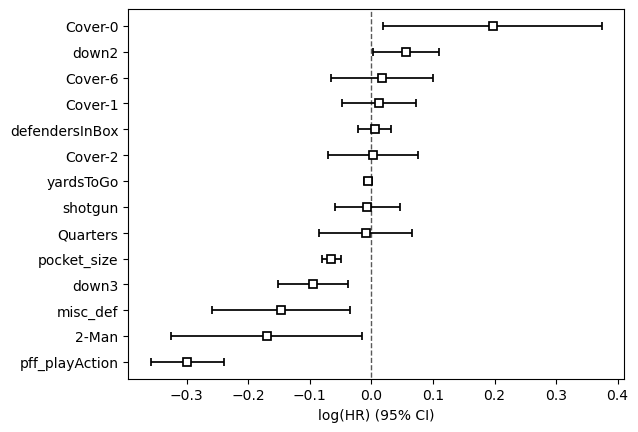

In [19]:
pass_ctv.plot()

In [20]:
X_test

array([7989, 7511, 7579, ..., 3131, 4585, 4865], shape=(1641,))

In [21]:
tvx.loc[tvx.id.isin([2486])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size
12952,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,0,5,4.7007
12953,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,5,10,4.0947
12954,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,10,15,3.9046
12955,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,15,20,3.6045
12956,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,True,False,2486,20,24,0.0000


In [22]:
pred = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin([2486]), tv_cols+base_feat+["pass_event"]]).values

In [23]:
pred

array([1.0273, 1.0685, 1.0818, 1.1031, 1.3944])

In [24]:
plot_pred = np.hstack([[pri]*5 for pri in pred])
np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])

array([1.6399e-04, 6.5641e-04, 1.1330e-03, 2.5680e-03, 4.8121e-03,
       1.2434e-02, 3.1731e-02, 6.1849e-02, 9.7734e-02, 1.4211e-01,
       1.8987e-01, 2.4219e-01, 3.0714e-01, 3.7936e-01, 4.6283e-01,
       5.5087e-01, 6.3520e-01, 7.2295e-01, 8.1682e-01, 9.0395e-01,
       1.2704e+00, 1.4107e+00, 1.4989e+00, 1.6091e+00, 1.6950e+00])

In [25]:
plot_pred

array([1.0273, 1.0273, 1.0273, 1.0273, 1.0273, 1.0685, 1.0685, 1.0685,
       1.0685, 1.0685, 1.0818, 1.0818, 1.0818, 1.0818, 1.0818, 1.1031,
       1.1031, 1.1031, 1.1031, 1.1031, 1.3944, 1.3944, 1.3944, 1.3944,
       1.3944])

In [26]:
pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]

array([1.5964e-04, 6.3899e-04, 1.1029e-03, 2.4998e-03, 4.6844e-03,
       1.1636e-02, 2.9696e-02, 5.7882e-02, 9.1465e-02, 1.3299e-01,
       1.7551e-01, 2.2387e-01, 2.8391e-01, 3.5067e-01, 4.2783e-01,
       4.9937e-01, 5.7582e-01, 6.5536e-01, 7.4046e-01, 8.1944e-01,
       9.1106e-01, 1.0117e+00, 1.0750e+00, 1.1540e+00, 1.2156e+00])

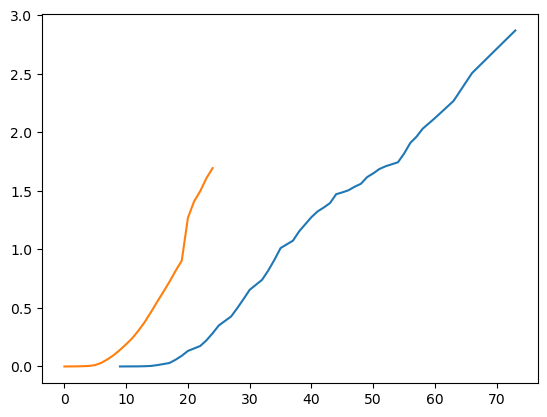

In [27]:
plt.plot(pass_ctv.baseline_cumulative_hazard_, label='baseline_cumulative_hazard')
plt.plot(np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]), label="basline*partial")

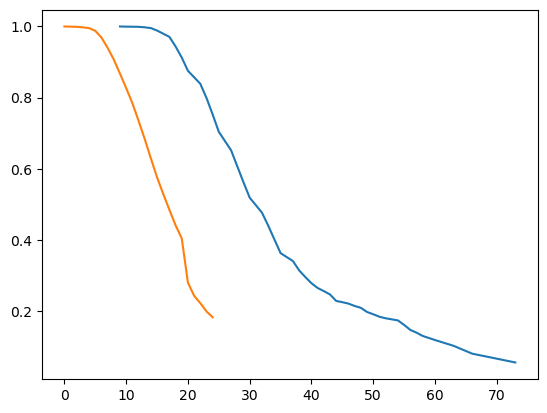

In [28]:
plt.plot(np.exp(-pass_ctv.baseline_cumulative_hazard_), label='baseline_cumulative_survival')
plt.plot(np.exp(-1*np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])), label="basline*partial")